In [1]:
import pandas as pd
import numpy as np
import glob
from tqdm.notebook import tqdm

def printShape(df, cols=[], msg=''):
    
    print(df.shape, end='  ')
    for col in cols:
        print(col, df[col].nunique(), end='  ')
    print(msg)
    
    return df

OPENALEX = '/scratch/fl1092/OpenAlex/openalex'
DIR = '../data/study_2_data'
LARGEFILE = '../data/large'

PaperIDtoInt = lambda x: int(x.replace('https://openalex.org/W', ''))

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

cm = 1/2.54  # centimeters in inches
font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

# Load data

## Load paper info

In [4]:
%%time
paperJournal = (
    pd.read_csv(f'{LARGEFILE}/PaperJournal.csv', usecols=['PaperID','JournalID'])
    .pipe(printShape)

    .drop_duplicates(subset=['PaperID'])
    .pipe(printShape, cols=['PaperID']) # 208261724
)

(215542989, 2)  
(208261724, 2)  PaperID 208261724  
CPU times: user 2min 50s, sys: 6.4 s, total: 2min 56s
Wall time: 3min


In [5]:
%%time
paperYear = (
    pd.read_csv(f'{LARGEFILE}/PaperYear.csv', usecols=['PaperID','Year'])
    .pipe(printShape, cols=['PaperID']) # 257748845
)

(257748845, 2)  PaperID 257748845  
CPU times: user 1min 48s, sys: 4.33 s, total: 1min 52s
Wall time: 1min 55s


In [6]:
%%time
paperOACount = (
    pd.read_csv(f'{LARGEFILE}/PaperCitingOACount.csv').pipe(printShape, cols=['CitingPaperID'])
    .query('is_oa==True')
    .pipe(printShape, cols=['CitingPaperID'])
    
    .drop(['is_oa'], axis=1)
    .rename(columns={'CitingPaperID':'PaperID'})

    .groupby('PaperID')['count'].sum().reset_index()
    .pipe(printShape, cols=['PaperID'])
) # 71458673

(155981427, 3)  CitingPaperID 87336219  
(71458850, 3)  CitingPaperID 71458673  
(71458673, 2)  PaperID 71458673  
CPU times: user 2min 10s, sys: 3.99 s, total: 2min 14s
Wall time: 2min 16s


In [7]:
%%time
totalRef = pd.read_csv(f'{LARGEFILE}/PaperReferencesCount.csv').pipe(printShape) # 87419190

(87419190, 2)  
CPU times: user 12.2 s, sys: 580 ms, total: 12.8 s
Wall time: 13.3 s


In [8]:
%%time
paperPaywalledPercent = (
    paperOACount
    .merge(totalRef, on='PaperID', how='right')
    .pipe(printShape, cols=['PaperID'])
    
    .fillna({'count': 0})
    .assign(Percent=lambda df: 1- (df['count'] / df.ReferencesCount)) # "count" is number of references that goes to OA papers

    .merge(paperJournal, on='PaperID')
    .pipe(printShape, cols=['PaperID'])

    .assign(Percent_within=lambda df: df.groupby('JournalID')['Percent'].transform(lambda x: x - np.mean(x)))
    .pipe(printShape)

    .drop(['JournalID'], axis=1)
) # 87419190

(87419190, 3)  PaperID 87419190  
(78821844, 5)  PaperID 78821844  
(78821844, 6)  
CPU times: user 3min 1s, sys: 8.38 s, total: 3min 9s
Wall time: 3min 11s


In [9]:
paperPaywalledPercent.head()

,PaperID,count,ReferencesCount,Percent,Percent_within
0,108,1.0,7,0.857143,-0.033340
1,125,1.0,4,0.750000,0.006431
2,147,3.0,5,0.400000,-0.311559
3,285,39.0,43,0.093023,-0.509040
4,504,2.0,32,0.937500,0.195328


In [11]:
%%time
paperField = (
    pd.read_csv(f'{OPENALEX}/cleaned_data/PaperFields_TopLevel.csv', usecols=['PaperID','TopLevelParent'])
    .pipe(printShape, cols=['PaperID'])
)

(844403231, 2)  PaperID 205190847  
CPU times: user 5min 13s, sys: 20.9 s, total: 5min 34s
Wall time: 5min 46s


# Compute embeddings

First train a doc2vec model using paper abstracts from OpenAlex (code is `../src/doc2vec.py`).

Then, compute embeddings of papers using `../src/ComputePaperVecDoc2vec.py`.

Finally, compute the diameter of referenced papers using `../src/refListDiameter.py`

# Analysis

In [17]:
%%time
aggDistance = pd.read_csv(f'{LARGEFILE}/CitationsPaperDistanceAggregated_30percent_all.csv').pipe(printShape)

(46887938, 9)  
CPU times: user 1min, sys: 6.14 s, total: 1min 6s
Wall time: 1min 13s


In [19]:
%%time
paywallDistance = (
    paperPaywalledPercent.rename(columns={'PaperID':'CitingPaper'})
    .pipe(printShape, cols=['CitingPaper'])
    
    .merge(aggDistance, on='CitingPaper')
    .pipe(printShape, cols=['CitingPaper'])

    .assign(Percentile_10=lambda df: pd.qcut(df['Percent'], 10, labels=False))
    .assign(Percentile_20=lambda df: pd.qcut(df['Percent'], 20, labels=False))

    .assign(Percentile_within_10=lambda df: pd.qcut(df['Percent_within'], 10, labels=False))
    .assign(Percentile_within_20=lambda df: pd.qcut(df['Percent_within'], 20, labels=False))
)   

(78821844, 5)  CitingPaper 78821844  
(43733176, 13)  CitingPaper 43733176  
CPU times: user 1min 55s, sys: 17 s, total: 2min 11s
Wall time: 2min 28s


In [20]:
import scipy
from matplotlib.ticker import AutoMinorLocator

def getCI(data, confidence=0.95):
    
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    return m, h


def plotCI(df, x, col, width=5, ax=None, lo=0, hi=0.14, left=-0.5, right=1.5):
    
    if ax is None: ax = plt.gca()
    
    color = '#e41a1c'
        
    means = df[col].apply(lambda x: x[0])
    errs = df[col].apply(lambda x: x[1])
    
    errs = df[col].apply(lambda x: x[1])
    
    plotline, caplines, barlinecols = ax.errorbar(
        x=x, y=means, yerr=errs, fmt = ' ', marker='_', ms=width+1, ecolor=(0, 0, 0, 0.2),
        elinewidth=width, capsize=0, color=color
    )

    plt.setp(barlinecols[0], capstyle="round", color=color, alpha=0.2)


def plotPointPlot(df, x, y, x_original, ax=None):
    
    if ax is None:
        ax = plt.gca()

    # df[y] = df[y].astype(int)
    
    toPlot = df.groupby(x).agg({y: getCI}).reset_index()
        
    plotCI(toPlot, x=toPlot[x], col=y, ax=ax, width=4)
    
    labelsDf = (
        df.groupby(x).agg({x_original:['min', 'max']}).reset_index()
        .assign(
            Label=lambda df: df.apply(
                lambda row: f"[{row[x_original, 'min']*100:.0f}%, {row[x_original, 'max']*100:.0f}%)", axis=1
            )
        )
    )
    
    xticksshow=[_ for _ in range(2, 20, 7)]
    xtickslabel=labelsDf.loc[xticksshow, 'Label'].values

    ax.set_xticks(xticksshow)
    ax.set_xticklabels(xtickslabel)
    
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(7))
    ax.tick_params('x', length=4, width=1, which='major')
    ax.tick_params(axis='y', which='minor', length=0)
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
    ax.set_ylim(1.56, 1.68)
    ax.set_yticks([1.56, 1.58, 1.60, 1.62, 1.64, 1.66, 1.68])
    
    return ax, labelsDf, toPlot

CPU times: user 3.33 s, sys: 718 ms, total: 4.04 s
Wall time: 11.9 s


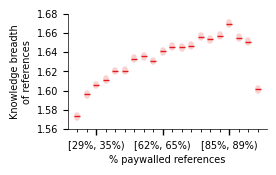

In [21]:
%%time
plt.figure(figsize=(6.5*cm, 3.8*cm))

ax, binsDf, yValues = plotPointPlot(paywallDistance, 'Percentile_20', 'Diameter_var', 'Percent', ax=None)
ax.set_xlabel('% paywalled references')
ax.set_ylabel('Knowledge breadth\nof references')

plt.savefig('../figures/Knowledge_breadth_all.pdf', bbox_inches = 'tight', pad_inches = 0)

In [22]:
binsDf

Percentile_20   Percent                  Label
                       min       max             
0              0  0.000000  0.210526    [0%, 21%)
1              1  0.210674  0.291667   [21%, 29%)
2              2  0.291740  0.352941   [29%, 35%)
3              3  0.352995  0.405063   [35%, 41%)
4              4  0.405099  0.454545   [41%, 45%)
5              5  0.454681  0.500000   [45%, 50%)
6              6  0.500603  0.538462   [50%, 54%)
7              7  0.538593  0.578947   [54%, 58%)
8              8  0.579082  0.615385   [58%, 62%)
9              9  0.615445  0.652174   [62%, 65%)
10            10  0.652185  0.688889   [65%, 69%)
11            11  0.688946  0.723077   [69%, 72%)
12            12  0.723112  0.756757   [72%, 76%)
13            13  0.756794  0.789474   [76%, 79%)
14            14  0.789572  0.821429   [79%, 82%)
15            15  0.821472  0.853081   [82%, 85%)
16            16  0.853093  0.886364   [85%, 89%)
17            17  0.886398  0.920000   [89%, 92%)
18            18  0.920036  0.956522   [92%, 96%)
19            19  0.956567  1.000000  [96%, 100%)